In [1]:
%matplotlib inline

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_blobs
from sklearn.svm import SVC
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


In [2]:
# Import excel file 

df = pd.read_excel("CTG.xls", sheet_name='Raw Data', header = 1)
df


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39
0,Variab10.txt,1996-12-01,CTG0001.txt,240.0,357.0,120.0,120.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0
1,Fmcs_1.txt,1996-05-03,CTG0002.txt,5.0,632.0,132.0,132.0,4.0,0.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
2,Fmcs_1.txt,1996-05-03,CTG0003.txt,177.0,779.0,133.0,133.0,2.0,0.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
3,Fmcs_1.txt,1996-05-03,CTG0004.txt,411.0,1192.0,134.0,134.0,2.0,0.0,6.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
4,Fmcs_1.txt,1996-05-03,CTG0005.txt,533.0,1147.0,132.0,132.0,4.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,S8001045.dsp,1998-06-06,CTG2127.txt,1576.0,3049.0,140.0,140.0,1.0,0.0,9.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0
2125,S8001045.dsp,1998-06-06,CTG2128.txt,2796.0,3415.0,142.0,142.0,1.0,1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2126,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2127,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Define column name
df.columns = ["FileName","Date","SegFile","b","e","LBE","LB","AC","FM","UC",
              "ASTV","MSTV","ALTV","MLTV","DL","DS","DP","DR","Width","Min",
              "Max","Nmax","Nzeros","Mode","Mean","Median","Variance","Tendency",
              "A","B","C","D","E","AD","DE","LD","FS","SUSP","CLASS","NSP"]
df

,FileName,Date,SegFile,b,e,LBE,LB,AC,FM,UC,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,Variab10.txt,1996-12-01,CTG0001.txt,240.0,357.0,120.0,120.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0
1,Fmcs_1.txt,1996-05-03,CTG0002.txt,5.0,632.0,132.0,132.0,4.0,0.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
2,Fmcs_1.txt,1996-05-03,CTG0003.txt,177.0,779.0,133.0,133.0,2.0,0.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
3,Fmcs_1.txt,1996-05-03,CTG0004.txt,411.0,1192.0,134.0,134.0,2.0,0.0,6.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
4,Fmcs_1.txt,1996-05-03,CTG0005.txt,533.0,1147.0,132.0,132.0,4.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,S8001045.dsp,1998-06-06,CTG2127.txt,1576.0,3049.0,140.0,140.0,1.0,0.0,9.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0
2125,S8001045.dsp,1998-06-06,CTG2128.txt,2796.0,3415.0,142.0,142.0,1.0,1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2126,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2127,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Delete the column that we didn't use it
df = df.drop(['FileName','Date','SegFile','LBE','b','e','DR','A','B','C','D','E','AD','DE','LD','FS','SUSP','CLASS'], axis=1)
df

,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,120.0,0.0,0.0,0.0,73.0,0.5,43.0,2.4,0.0,0.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,4.0,0.0,4.0,17.0,2.1,0.0,10.4,2.0,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,2.0,0.0,5.0,16.0,2.1,0.0,13.4,2.0,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,2.0,0.0,6.0,16.0,2.4,0.0,23.0,2.0,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,4.0,0.0,5.0,16.0,2.4,0.0,19.9,0.0,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,140.0,1.0,0.0,9.0,78.0,0.4,27.0,7.0,0.0,0.0,...,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,2.0
2125,142.0,1.0,1.0,5.0,74.0,0.4,36.0,5.0,0.0,0.0,...,117.0,159.0,2.0,1.0,145.0,143.0,145.0,1.0,0.0,1.0
2126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Check missing data
df.isnull().sum()

LB          3
AC          3
FM          2
UC          2
ASTV        2
MSTV        2
ALTV        2
MLTV        2
DL          1
DS          1
DP          1
Width       3
Min         3
Max         3
Nmax        3
Nzeros      3
Mode        3
Mean        3
Median      3
Variance    3
Tendency    3
NSP         3
dtype: int64

In [6]:
# drop rows with missing data
df = df.dropna(axis=0)
df

,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,120.0,0.0,0.0,0.0,73.0,0.5,43.0,2.4,0.0,0.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,4.0,0.0,4.0,17.0,2.1,0.0,10.4,2.0,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,2.0,0.0,5.0,16.0,2.1,0.0,13.4,2.0,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,2.0,0.0,6.0,16.0,2.4,0.0,23.0,2.0,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,4.0,0.0,5.0,16.0,2.4,0.0,19.9,0.0,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.0,0.0,6.0,79.0,0.2,25.0,7.2,0.0,0.0,...,137.0,177.0,4.0,0.0,153.0,150.0,152.0,2.0,0.0,2.0
2122,140.0,1.0,0.0,9.0,78.0,0.4,22.0,7.1,0.0,0.0,...,103.0,169.0,6.0,0.0,152.0,148.0,151.0,3.0,1.0,2.0
2123,140.0,1.0,0.0,7.0,79.0,0.4,20.0,6.1,0.0,0.0,...,103.0,170.0,5.0,0.0,153.0,148.0,152.0,4.0,1.0,2.0
2124,140.0,1.0,0.0,9.0,78.0,0.4,27.0,7.0,0.0,0.0,...,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,2.0


In [7]:
# Tendency is nominal so we have to use OneHotEncoder
encoder = OneHotEncoder()
encoded = encoder.fit_transform(df[["Tendency"]])
encoded

<2126x3 sparse matrix of type '<class 'numpy.float64'>'
	with 2126 stored elements in Compressed Sparse Row format>

In [8]:
# We create a new dataframe with our one-hot columns
encoded_df = pd.DataFrame(encoded.toarray(), columns = ["Tendency"+str(i) for i in range(0,len(encoded.toarray()[0]))])
merged_df = df.join(encoded_df)
merged_df

,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,...,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP,Tendency0,Tendency1,Tendency2
0,120.0,0.0,0.0,0.0,73.0,0.5,43.0,2.4,0.0,0.0,...,0.0,120.0,137.0,121.0,73.0,1.0,2.0,0.0,0.0,1.0
1,132.0,4.0,0.0,4.0,17.0,2.1,0.0,10.4,2.0,0.0,...,1.0,141.0,136.0,140.0,12.0,0.0,1.0,0.0,1.0,0.0
2,133.0,2.0,0.0,5.0,16.0,2.1,0.0,13.4,2.0,0.0,...,1.0,141.0,135.0,138.0,13.0,0.0,1.0,0.0,1.0,0.0
3,134.0,2.0,0.0,6.0,16.0,2.4,0.0,23.0,2.0,0.0,...,0.0,137.0,134.0,137.0,13.0,1.0,1.0,0.0,0.0,1.0
4,132.0,4.0,0.0,5.0,16.0,2.4,0.0,19.9,0.0,0.0,...,0.0,137.0,136.0,138.0,11.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.0,0.0,6.0,79.0,0.2,25.0,7.2,0.0,0.0,...,0.0,153.0,150.0,152.0,2.0,0.0,2.0,0.0,1.0,0.0
2122,140.0,1.0,0.0,9.0,78.0,0.4,22.0,7.1,0.0,0.0,...,0.0,152.0,148.0,151.0,3.0,1.0,2.0,0.0,0.0,1.0
2123,140.0,1.0,0.0,7.0,79.0,0.4,20.0,6.1,0.0,0.0,...,0.0,153.0,148.0,152.0,4.0,1.0,2.0,0.0,0.0,1.0
2124,140.0,1.0,0.0,9.0,78.0,0.4,27.0,7.0,0.0,0.0,...,0.0,152.0,147.0,151.0,4.0,1.0,2.0,0.0,0.0,1.0


In [9]:
merged_df = merged_df.drop(["Tendency"], axis=1)
merged_df

,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,...,Nmax,Nzeros,Mode,Mean,Median,Variance,NSP,Tendency0,Tendency1,Tendency2
0,120.0,0.0,0.0,0.0,73.0,0.5,43.0,2.4,0.0,0.0,...,2.0,0.0,120.0,137.0,121.0,73.0,2.0,0.0,0.0,1.0
1,132.0,4.0,0.0,4.0,17.0,2.1,0.0,10.4,2.0,0.0,...,6.0,1.0,141.0,136.0,140.0,12.0,1.0,0.0,1.0,0.0
2,133.0,2.0,0.0,5.0,16.0,2.1,0.0,13.4,2.0,0.0,...,5.0,1.0,141.0,135.0,138.0,13.0,1.0,0.0,1.0,0.0
3,134.0,2.0,0.0,6.0,16.0,2.4,0.0,23.0,2.0,0.0,...,11.0,0.0,137.0,134.0,137.0,13.0,1.0,0.0,0.0,1.0
4,132.0,4.0,0.0,5.0,16.0,2.4,0.0,19.9,0.0,0.0,...,9.0,0.0,137.0,136.0,138.0,11.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.0,0.0,6.0,79.0,0.2,25.0,7.2,0.0,0.0,...,4.0,0.0,153.0,150.0,152.0,2.0,2.0,0.0,1.0,0.0
2122,140.0,1.0,0.0,9.0,78.0,0.4,22.0,7.1,0.0,0.0,...,6.0,0.0,152.0,148.0,151.0,3.0,2.0,0.0,0.0,1.0
2123,140.0,1.0,0.0,7.0,79.0,0.4,20.0,6.1,0.0,0.0,...,5.0,0.0,153.0,148.0,152.0,4.0,2.0,0.0,0.0,1.0
2124,140.0,1.0,0.0,9.0,78.0,0.4,27.0,7.0,0.0,0.0,...,6.0,0.0,152.0,147.0,151.0,4.0,2.0,0.0,0.0,1.0


In [10]:
# Check the data information

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2126 entries, 0 to 2125
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LB         2126 non-null   float64
 1   AC         2126 non-null   float64
 2   FM         2126 non-null   float64
 3   UC         2126 non-null   float64
 4   ASTV       2126 non-null   float64
 5   MSTV       2126 non-null   float64
 6   ALTV       2126 non-null   float64
 7   MLTV       2126 non-null   float64
 8   DL         2126 non-null   float64
 9   DS         2126 non-null   float64
 10  DP         2126 non-null   float64
 11  Width      2126 non-null   float64
 12  Min        2126 non-null   float64
 13  Max        2126 non-null   float64
 14  Nmax       2126 non-null   float64
 15  Nzeros     2126 non-null   float64
 16  Mode       2126 non-null   float64
 17  Mean       2126 non-null   float64
 18  Median     2126 non-null   float64
 19  Variance   2126 non-null   float64
 20  NSP     

In [11]:
# Check our target variable
merged_df["NSP"].unique()

array([2., 1., 3.])

# Data Visualization

[Text(0, 0, 'Normal'), Text(1, 0, 'suspect'), Text(2, 0, 'pathologic')]

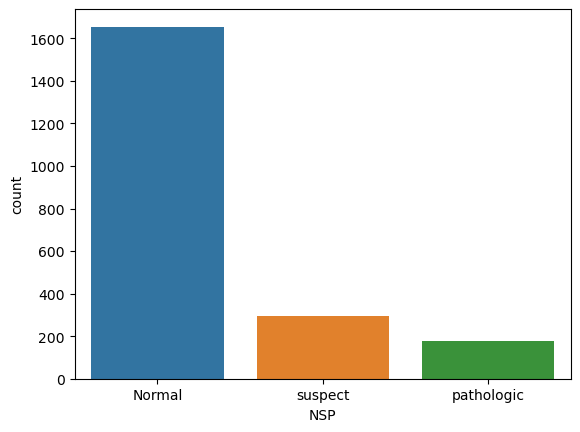

In [12]:
NSP_count=sns.countplot(data=merged_df,x='NSP')
NSP_count.set_xticklabels(['Normal','suspect','pathologic'])


# Support Vector Machine

# Linear method

In [13]:
#drop the data column and create new to train the model

datapoints = merged_df.drop('NSP', axis=1).values
labels = np.array(merged_df["NSP"])

In [14]:
#Grid search
model = SVC(kernel='linear')
parameters = {
              'C': [0.1, 1, 10, 100, 0.005],
             }
gridsearch = GridSearchCV(estimator=model, param_grid=parameters, cv=5)
gridsearch.fit(datapoints, labels)

GridSearchCV(cv=5, estimator=SVC(kernel='linear'),
             param_grid={'C': [0.1, 1, 10, 100, 0.005]})

In [15]:
#search whether what C is the best one
gridsearch.best_params_

{'C': 0.1}

In [16]:
# The next line creates a classifier, with C set to 0.1 refer to best params
model = SVC(C=0.1, kernel='linear')

# fit our data:
now=time.time()
model.fit(datapoints, labels)
end=time.time()
duration=end-now
print("Duration: {}".format(duration)) #Training time

Duration: 0.6352605819702148


In [17]:
#Check validation score
scores = cross_val_score(model, datapoints, labels, cv=10)
scores.mean()

0.8625919036229958

In [18]:
#Check accuracy score
data_train, data_test, labels_train, labels_test = train_test_split(datapoints, labels, test_size=0.33, random_state=42)

model.fit(data_train, labels_train)

predictions_test = model.predict(data_test)

acc_test = accuracy_score(labels_test, predictions_test)

print("Accuracy on test data: ", acc_test)

Accuracy on test data:  0.896011396011396


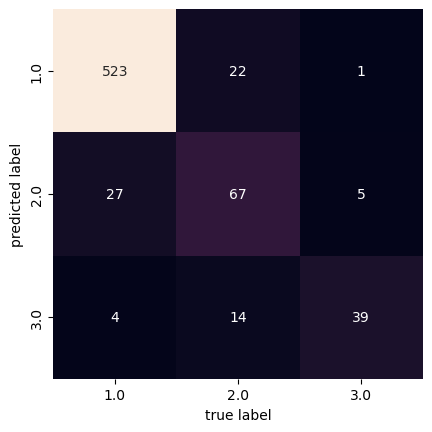

In [19]:
classes = pd.Series(labels).unique()
#Confusion Matrix
mat = confusion_matrix(labels_test, predictions_test)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('true label')
plt.ylabel('predicted label');

# Resample

In [20]:
df_training = pd.DataFrame(data_train)
df_training["NSP"] = labels_train
df_class1 = df_training[df_training["NSP"] == 1]
df_class2 = df_training[df_training["NSP"] == 2]
df_class3 = df_training[df_training["NSP"] == 3]

df_class1

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,NSP
0,132.0,0.0,0.0,3.0,16.0,2.5,0.0,33.5,0.0,0.0,...,9.0,1.0,136.0,131.0,134.0,15.0,0.0,0.0,1.0,1.0
1,130.0,2.0,0.0,5.0,33.0,1.1,0.0,16.4,0.0,0.0,...,3.0,0.0,133.0,133.0,134.0,4.0,0.0,1.0,0.0,1.0
2,131.0,5.0,0.0,5.0,24.0,1.3,0.0,7.3,0.0,0.0,...,2.0,0.0,136.0,138.0,139.0,5.0,0.0,1.0,0.0,1.0
4,133.0,2.0,0.0,6.0,50.0,0.9,1.0,10.8,0.0,0.0,...,2.0,1.0,135.0,136.0,137.0,3.0,0.0,1.0,0.0,1.0
5,157.0,9.0,4.0,2.0,49.0,0.7,0.0,4.9,0.0,0.0,...,0.0,0.0,163.0,166.0,166.0,6.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1419,130.0,10.0,1.0,4.0,52.0,1.3,0.0,2.4,1.0,0.0,...,6.0,0.0,144.0,141.0,144.0,16.0,0.0,0.0,1.0,1.0
1420,123.0,12.0,0.0,2.0,22.0,2.2,0.0,6.7,0.0,0.0,...,2.0,0.0,131.0,132.0,133.0,4.0,0.0,1.0,0.0,1.0
1421,122.0,4.0,0.0,3.0,20.0,2.6,0.0,17.7,4.0,0.0,...,6.0,0.0,131.0,121.0,126.0,31.0,0.0,1.0,0.0,1.0
1422,115.0,3.0,0.0,8.0,24.0,1.6,0.0,10.1,2.0,0.0,...,3.0,2.0,133.0,122.0,129.0,45.0,0.0,1.0,0.0,1.0


In [21]:
df_class2_resampled = resample(df_class2,random_state=42,n_samples=1101,replace=2)
df_class2_resampled

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,NSP
666,143.0,0.0,0.0,0.0,65.0,0.5,24.0,10.4,0.0,0.0,...,4.0,0.0,143.0,144.0,145.0,1.0,0.0,0.0,1.0,2.0
1336,148.0,0.0,1.0,0.0,61.0,0.5,39.0,6.3,1.0,0.0,...,2.0,0.0,154.0,152.0,154.0,1.0,0.0,0.0,1.0,2.0
577,142.0,0.0,0.0,5.0,58.0,0.4,31.0,6.1,0.0,0.0,...,2.0,0.0,155.0,153.0,155.0,1.0,0.0,1.0,0.0,2.0
126,146.0,0.0,3.0,0.0,77.0,0.2,42.0,4.6,0.0,0.0,...,1.0,0.0,142.0,142.0,143.0,0.0,0.0,1.0,0.0,2.0
711,137.0,1.0,0.0,6.0,62.0,0.4,42.0,5.4,0.0,0.0,...,2.0,0.0,142.0,140.0,142.0,0.0,0.0,1.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,159.0,0.0,0.0,4.0,65.0,0.4,16.0,10.8,0.0,0.0,...,0.0,0.0,163.0,163.0,165.0,2.0,0.0,0.0,1.0,2.0
820,140.0,0.0,0.0,3.0,48.0,0.9,21.0,9.5,0.0,0.0,...,2.0,1.0,151.0,152.0,152.0,3.0,0.0,1.0,0.0,2.0
507,125.0,0.0,6.0,1.0,66.0,0.3,46.0,5.8,0.0,0.0,...,0.0,0.0,125.0,124.0,126.0,0.0,0.0,1.0,0.0,2.0
1052,145.0,0.0,0.0,1.0,62.0,0.5,8.0,10.1,1.0,0.0,...,1.0,1.0,148.0,145.0,148.0,4.0,0.0,0.0,1.0,2.0


In [22]:
df_class3_resampled = resample(df_class3,random_state=42,n_samples=1101,replace=3)
df_class3_resampled

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,NSP
1112,128.0,0.0,2.0,8.0,65.0,2.5,0.0,0.0,6.0,0.0,...,6.0,0.0,104.0,94.0,115.0,28.0,0.0,1.0,0.0,3.0
995,150.0,0.0,9.0,0.0,71.0,0.4,18.0,7.9,0.0,0.0,...,0.0,0.0,151.0,151.0,152.0,0.0,0.0,0.0,1.0,3.0
192,132.0,0.0,0.0,8.0,32.0,1.3,0.0,14.2,1.0,0.0,...,2.0,3.0,99.0,117.0,125.0,61.0,0.0,0.0,1.0,3.0
1135,122.0,0.0,0.0,1.0,84.0,0.5,5.0,13.6,0.0,0.0,...,0.0,0.0,122.0,122.0,123.0,3.0,0.0,0.0,1.0,3.0
765,134.0,0.0,0.0,0.0,83.0,0.2,64.0,3.5,0.0,0.0,...,1.0,0.0,135.0,134.0,136.0,0.0,0.0,1.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,133.0,0.0,1.0,6.0,60.0,2.8,0.0,7.7,2.0,0.0,...,5.0,0.0,119.0,100.0,111.0,53.0,0.0,1.0,0.0,3.0
38,131.0,0.0,193.0,1.0,61.0,1.9,0.0,12.3,1.0,0.0,...,11.0,0.0,134.0,120.0,131.0,57.0,0.0,1.0,0.0,3.0
596,148.0,0.0,3.0,1.0,72.0,0.3,74.0,4.6,0.0,0.0,...,0.0,0.0,150.0,148.0,150.0,0.0,0.0,0.0,1.0,3.0
765,134.0,0.0,0.0,0.0,83.0,0.2,64.0,3.5,0.0,0.0,...,1.0,0.0,135.0,134.0,136.0,0.0,0.0,1.0,0.0,3.0


In [23]:
df_resampled = df_class1.append(df_class2_resampled)
df_resampled = df_resampled.append(df_class3_resampled)

df_resampled

C:\Users\nanoh\AppData\Local\Temp\ipykernel_18356\1060845850.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_resampled = df_class1.append(df_class2_resampled)
C:\Users\nanoh\AppData\Local\Temp\ipykernel_18356\1060845850.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_resampled = df_resampled.append(df_class3_resampled)


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,NSP
0,132.0,0.0,0.0,3.0,16.0,2.5,0.0,33.5,0.0,0.0,...,9.0,1.0,136.0,131.0,134.0,15.0,0.0,0.0,1.0,1.0
1,130.0,2.0,0.0,5.0,33.0,1.1,0.0,16.4,0.0,0.0,...,3.0,0.0,133.0,133.0,134.0,4.0,0.0,1.0,0.0,1.0
2,131.0,5.0,0.0,5.0,24.0,1.3,0.0,7.3,0.0,0.0,...,2.0,0.0,136.0,138.0,139.0,5.0,0.0,1.0,0.0,1.0
4,133.0,2.0,0.0,6.0,50.0,0.9,1.0,10.8,0.0,0.0,...,2.0,1.0,135.0,136.0,137.0,3.0,0.0,1.0,0.0,1.0
5,157.0,9.0,4.0,2.0,49.0,0.7,0.0,4.9,0.0,0.0,...,0.0,0.0,163.0,166.0,166.0,6.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,133.0,0.0,1.0,6.0,60.0,2.8,0.0,7.7,2.0,0.0,...,5.0,0.0,119.0,100.0,111.0,53.0,0.0,1.0,0.0,3.0
38,131.0,0.0,193.0,1.0,61.0,1.9,0.0,12.3,1.0,0.0,...,11.0,0.0,134.0,120.0,131.0,57.0,0.0,1.0,0.0,3.0
596,148.0,0.0,3.0,1.0,72.0,0.3,74.0,4.6,0.0,0.0,...,0.0,0.0,150.0,148.0,150.0,0.0,0.0,0.0,1.0,3.0
765,134.0,0.0,0.0,0.0,83.0,0.2,64.0,3.5,0.0,0.0,...,1.0,0.0,135.0,134.0,136.0,0.0,0.0,1.0,0.0,3.0


# Linear method - Test after resample

In [24]:
resample_labels_train = np.array(df_resampled["NSP"])
resample_data_train = df_resampled.drop(["NSP"], axis=1).values

In [25]:
#Grid search
model = SVC(kernel='linear')
parameters = {
              'C': [0.1, 1, 10, 100, 0.005],
             }
gridsearch = GridSearchCV(estimator=model, param_grid=parameters, cv=5)
gridsearch.fit(resample_data_train, resample_labels_train)

GridSearchCV(cv=5, estimator=SVC(kernel='linear'),
             param_grid={'C': [0.1, 1, 10, 100, 0.005]})

In [26]:
gridsearch.best_params_

{'C': 0.1}

In [27]:
#C set to 1 refer to beat params
model = SVC(C=0.1, kernel='linear')

#fit our data:
now=time.time()
model.fit(resample_data_train, resample_labels_train)
end=time.time()
duration=end-now
print("Duration: {}".format(duration)) #Training time

Duration: 3.074092149734497


In [28]:
#Check accuracy

predictions = model.predict(data_test)
acc_test = accuracy_score(labels_test, predictions)
print("Accuracy on test data: ", acc_test)

Accuracy on test data:  0.8390313390313391


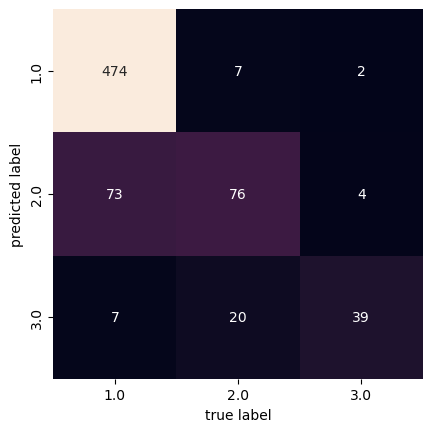

In [29]:
# Confusion metrix
mat = confusion_matrix(labels_test, predictions)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('true label')
plt.ylabel('predicted label');


# Non-linear method (RBF)

In [30]:
model = SVC(kernel='rbf')

parameters = {
              'C': [0.1, 1, 100, 1000],
              'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]
             }

gridsearch = GridSearchCV(estimator=model, param_grid=parameters, cv=5)
gridsearch.fit(datapoints, labels)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 100, 1000],
                         'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]})

In [31]:
gridsearch.best_params_

{'C': 1, 'gamma': 0.0001}

In [32]:
model = SVC(gamma=0.0001, C=1, kernel='rbf')

now=time.time()
model.fit(datapoints, labels)
end=time.time()
duration=end-now
print("Duration: {}".format(duration)) #training time

Duration: 0.07978606224060059


In [33]:
#Check val score
scores = cross_val_score(model, datapoints, labels, cv=10)
scores.mean()

0.8531778722650367

In [34]:
#Check accuracy
data_train, data_test, labels_train, labels_test = train_test_split(datapoints, labels, test_size=0.33, random_state=42)

model.fit(data_train, labels_train)

predictions_test = model.predict(data_test)

acc_test = accuracy_score(labels_test, predictions_test)

print("Accuracy on test data: ", acc_test)

Accuracy on test data:  0.9088319088319088


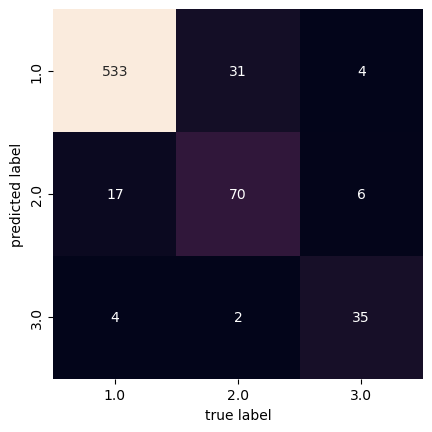

In [35]:
# Confusion Matrix
mat = confusion_matrix(labels_test, predictions_test)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('true label')
plt.ylabel('predicted label');

# Non-linear method - Test after resample

In [37]:
model = SVC(kernel='rbf')

parameters = {
              'C': [0.1, 1, 100, 1000],
              'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]
             }
gridsearch = GridSearchCV(estimator=model, param_grid=parameters, cv=5)
gridsearch.fit(resample_data_train, resample_labels_train)


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 100, 1000],
                         'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]})

In [38]:
gridsearch.best_params_

{'C': 1, 'gamma': 1}

In [39]:
#C = 1 and gamma = 1 refer to best params
model = SVC(gamma=1, C=1, kernel='rbf')

now=time.time()
model.fit(resample_data_train, resample_labels_train) #fit the model
end=time.time()
duration=end-now
print("Duration: {}".format(duration)) #Training time

Duration: 0.6882221698760986


In [40]:
#Check accuracy

predictions = model.predict(data_test)
acc_test = accuracy_score(labels_test, predictions)
print("Accuracy on test data: ", acc_test)

Accuracy on test data:  0.792022792022792


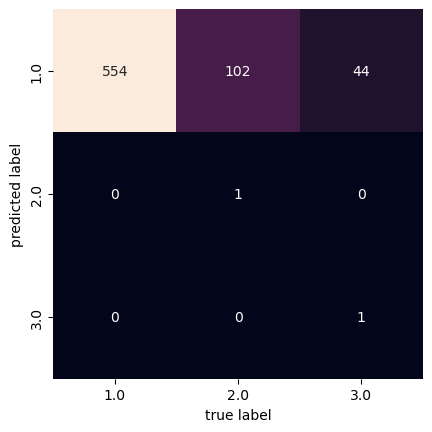

In [41]:
#Consusion matrix

mat = confusion_matrix(labels_test, predictions)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('true label')
plt.ylabel('predicted label');

# Neural Network

Model 1

In [42]:
data_train, data_test, labels_train, labels_test = train_test_split(datapoints, labels, test_size=0.33, random_state=42)

In [43]:
data_train.shape, labels_train.shape, data_test.shape, labels_test.shape

((1424, 23), (1424,), (702, 23), (702,))

In [44]:
model_1 = Sequential([layers.Input(23),
                      layers.Dense(4, activation='softmax')])
opt_1 = Adam(learning_rate=0.001)
model_1.compile(optimizer=opt_1, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [45]:
#Fit the model
history=model_1.fit(x=data_train, y=labels_train, validation_data=(data_test, labels_test), epochs=30)

Epoch 1/30
45/45 [==============================] - 1s 6ms/step - loss: 22.5815 - accuracy: 0.3125 - val_loss: 7.7121 - val_accuracy: 0.6581
Epoch 2/30
45/45 [==============================] - 0s 2ms/step - loss: 8.8469 - accuracy: 0.6587 - val_loss: 6.8765 - val_accuracy: 0.6581
Epoch 3/30
45/45 [==============================] - 0s 2ms/step - loss: 7.8407 - accuracy: 0.6412 - val_loss: 6.0482 - val_accuracy: 0.6852
Epoch 4/30
45/45 [==============================] - 0s 2ms/step - loss: 6.8775 - accuracy: 0.6489 - val_loss: 5.2325 - val_accuracy: 0.6624
Epoch 5/30
45/45 [==============================] - 0s 2ms/step - loss: 5.9721 - accuracy: 0.6636 - val_loss: 4.4753 - val_accuracy: 0.6781
Epoch 6/30
45/45 [==============================] - 0s 2ms/step - loss: 5.2020 - accuracy: 0.6945 - val_loss: 3.8748 - val_accuracy: 0.6909
Epoch 7/30
45/45 [==============================] - 0s 2ms/step - loss: 4.5571 - accuracy: 0.6805 - val_loss: 3.3160 - val_accuracy: 0.7265
Epoch 8/30
45/45 [=

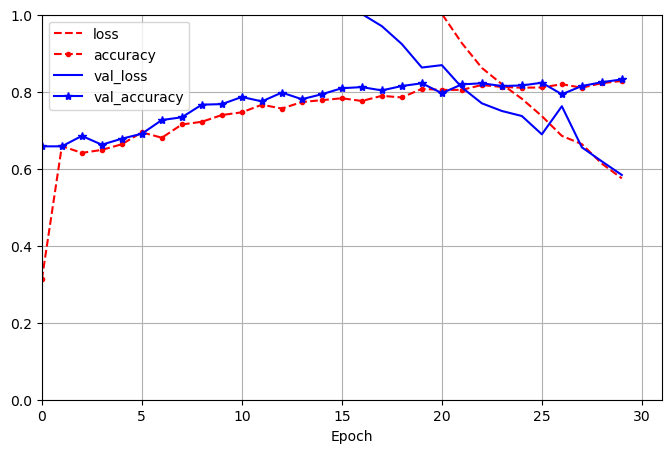

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 96        
                                                                 
Total params: 96
Trainable params: 96
Non-trainable params: 0
_________________________________________________________________


In [46]:
#Draw graph
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 31], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.show()

#Summary
model_1.summary()

Model 2: add hidden layers

In [47]:
opt_2 = Adam(learning_rate=0.001)

model_2 = Sequential([layers.Input(23),
                     layers.Dense(100, activation='relu'),
                     layers.Dense(5, activation='softmax')])

model_2.compile(optimizer=opt_2, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [48]:
history=model_2.fit(x=data_train, y=labels_train, validation_data=(data_test, labels_test), epochs=30)

Epoch 1/30
45/45 [==============================] - 1s 6ms/step - loss: 5.7611 - accuracy: 0.6917 - val_loss: 1.6685 - val_accuracy: 0.7920
Epoch 2/30
45/45 [==============================] - 0s 3ms/step - loss: 1.2821 - accuracy: 0.7914 - val_loss: 0.9531 - val_accuracy: 0.7635
Epoch 3/30
45/45 [==============================] - 0s 3ms/step - loss: 0.9479 - accuracy: 0.7928 - val_loss: 0.7192 - val_accuracy: 0.8177
Epoch 4/30
45/45 [==============================] - 0s 3ms/step - loss: 0.6359 - accuracy: 0.8258 - val_loss: 0.5372 - val_accuracy: 0.8162
Epoch 5/30
45/45 [==============================] - 0s 3ms/step - loss: 0.5522 - accuracy: 0.8434 - val_loss: 0.4890 - val_accuracy: 0.8561
Epoch 6/30
45/45 [==============================] - 0s 3ms/step - loss: 0.5052 - accuracy: 0.8371 - val_loss: 0.4093 - val_accuracy: 0.8718
Epoch 7/30
45/45 [==============================] - 0s 3ms/step - loss: 0.4844 - accuracy: 0.8399 - val_loss: 0.4167 - val_accuracy: 0.8561
Epoch 8/30
45/45 [==

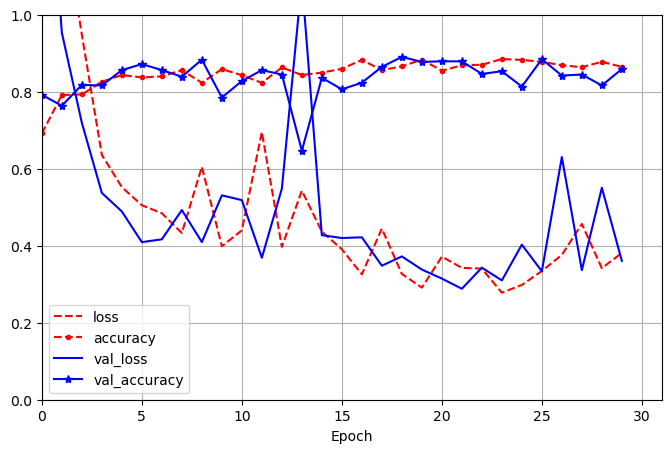

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 100)               2400      
                                                                 
 dense_2 (Dense)             (None, 5)                 505       
                                                                 
Total params: 2,905
Trainable params: 2,905
Non-trainable params: 0
_________________________________________________________________


In [49]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 31], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.show()

model_2.summary()

Model 3: Increase learning rate

In [50]:
opt_3 = Adam(learning_rate=0.01)

model_3 = Sequential([layers.Input(23),
                     layers.Dense(100, activation='relu'),
                     layers.Dense(5, activation='softmax')])

In [51]:
model_3.compile(optimizer=opt_3, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history=model_3.fit(x=data_train, y=labels_train, validation_data=(data_test, labels_test), epochs=30)

Epoch 1/30
45/45 [==============================] - 1s 5ms/step - loss: 9.8064 - accuracy: 0.7212 - val_loss: 1.0508 - val_accuracy: 0.8419
Epoch 2/30
45/45 [==============================] - 0s 2ms/step - loss: 1.2710 - accuracy: 0.8069 - val_loss: 1.5957 - val_accuracy: 0.7393
Epoch 3/30
45/45 [==============================] - 0s 3ms/step - loss: 1.1465 - accuracy: 0.7971 - val_loss: 0.8819 - val_accuracy: 0.8148
Epoch 4/30
45/45 [==============================] - 0s 3ms/step - loss: 0.9286 - accuracy: 0.8181 - val_loss: 1.0520 - val_accuracy: 0.7037
Epoch 5/30
45/45 [==============================] - 0s 3ms/step - loss: 1.2460 - accuracy: 0.8020 - val_loss: 2.5631 - val_accuracy: 0.8177
Epoch 6/30
45/45 [==============================] - 0s 3ms/step - loss: 0.8798 - accuracy: 0.8216 - val_loss: 1.0005 - val_accuracy: 0.8305
Epoch 7/30
45/45 [==============================] - 0s 3ms/step - loss: 0.7455 - accuracy: 0.8258 - val_loss: 0.7982 - val_accuracy: 0.8120
Epoch 8/30
45/45 [==

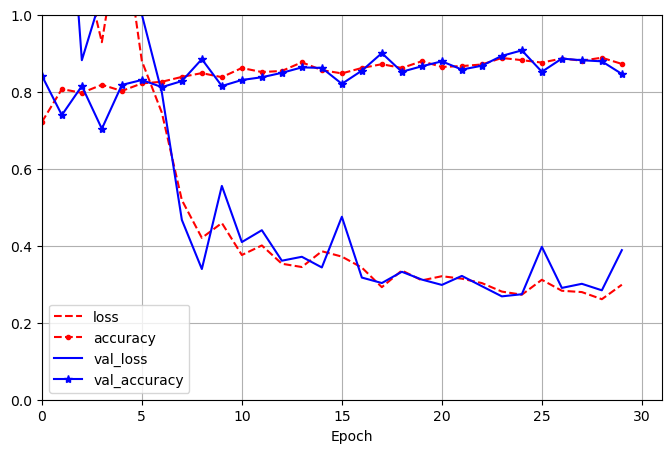

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               2400      
                                                                 
 dense_4 (Dense)             (None, 5)                 505       
                                                                 
Total params: 2,905
Trainable params: 2,905
Non-trainable params: 0
_________________________________________________________________


In [52]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 31], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.show()

model_3.summary()

Model 4: Add more layers

In [53]:
opt_4 = Adam(learning_rate=0.01)

model_4 = Sequential([layers.Input(23),
                     layers.Dense(100, activation='relu'),
                     layers.Dense(100, activation='relu'),
                     layers.Dense(100, activation='relu'),
                     layers.Dense(5, activation='softmax')])

In [54]:
model_4.compile(optimizer=opt_4, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history=model_4.fit(x=data_train, y=labels_train, validation_data=(data_test, labels_test), epochs=30)

Epoch 1/30
45/45 [==============================] - 1s 5ms/step - loss: 4.1611 - accuracy: 0.7310 - val_loss: 0.3823 - val_accuracy: 0.8362
Epoch 2/30
45/45 [==============================] - 0s 3ms/step - loss: 0.4029 - accuracy: 0.8504 - val_loss: 0.4180 - val_accuracy: 0.8462
Epoch 3/30
45/45 [==============================] - 0s 3ms/step - loss: 0.3964 - accuracy: 0.8448 - val_loss: 0.3656 - val_accuracy: 0.8533
Epoch 4/30
45/45 [==============================] - 0s 3ms/step - loss: 0.4340 - accuracy: 0.8265 - val_loss: 0.5158 - val_accuracy: 0.7792
Epoch 5/30
45/45 [==============================] - 0s 3ms/step - loss: 0.4112 - accuracy: 0.8322 - val_loss: 0.3507 - val_accuracy: 0.8675
Epoch 6/30
45/45 [==============================] - 0s 3ms/step - loss: 0.3588 - accuracy: 0.8483 - val_loss: 0.5385 - val_accuracy: 0.7949
Epoch 7/30
45/45 [==============================] - 0s 3ms/step - loss: 0.3858 - accuracy: 0.8476 - val_loss: 0.3641 - val_accuracy: 0.8433
Epoch 8/30
45/45 [==

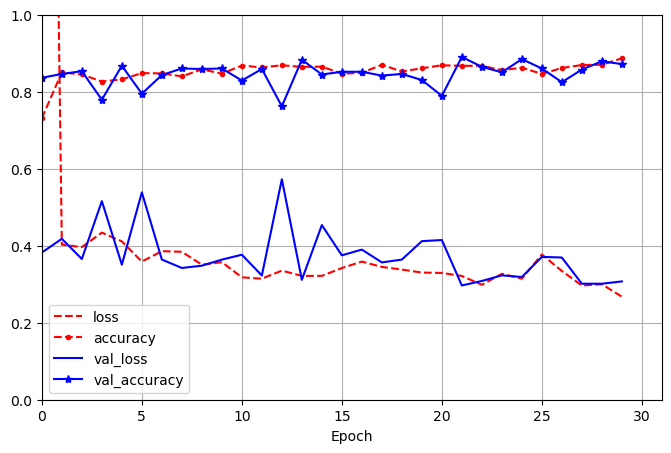

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 100)               2400      
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 100)               10100     
                                                                 
 dense_8 (Dense)             (None, 5)                 505       
                                                                 
Total params: 23,105
Trainable params: 23,105
Non-trainable params: 0
_________________________________________________________________


In [55]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 31], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.show()

model_4.summary()

Model 5: Drop out and regularizer

In [56]:
from tensorflow.keras.regularizers import L2

In [57]:
opt_5 = Adam(learning_rate=0.01)

model_5 = Sequential([layers.Input(23),
                     layers.Dense(100, activation='relu', kernel_regularizer=L2(0.001)),
                     layers.Dropout(0.2),
                     layers.Dense(100, activation='relu', kernel_regularizer=L2(0.001)),
                     layers.Dropout(0.2),
                     layers.Dense(100, activation='relu', kernel_regularizer=L2(0.001)),
                     layers.Dropout(0.2),
                     layers.Dense(4, activation='softmax')
                     ])

In [58]:
model_5.compile(optimizer=opt_5, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
now=time.time()
history=model_5.fit(x=data_train, y=labels_train, validation_data=(data_test, labels_test), epochs=30)
end=time.time()
duration=end-now
print("Duration: {}".format(duration))

Epoch 1/30
45/45 [==============================] - 1s 7ms/step - loss: 4.6869 - accuracy: 0.6791 - val_loss: 0.7012 - val_accuracy: 0.7906
Epoch 2/30
45/45 [==============================] - 0s 3ms/step - loss: 0.7515 - accuracy: 0.8069 - val_loss: 0.6730 - val_accuracy: 0.8006
Epoch 3/30
45/45 [==============================] - 0s 5ms/step - loss: 0.6824 - accuracy: 0.8167 - val_loss: 0.6214 - val_accuracy: 0.8034
Epoch 4/30
45/45 [==============================] - 0s 4ms/step - loss: 0.7052 - accuracy: 0.8139 - val_loss: 0.5784 - val_accuracy: 0.8533
Epoch 5/30
45/45 [==============================] - 0s 4ms/step - loss: 0.6448 - accuracy: 0.8251 - val_loss: 0.5619 - val_accuracy: 0.8618
Epoch 6/30
45/45 [==============================] - 0s 4ms/step - loss: 0.6347 - accuracy: 0.8181 - val_loss: 0.5713 - val_accuracy: 0.8091
Epoch 7/30
45/45 [==============================] - 0s 4ms/step - loss: 0.6212 - accuracy: 0.8216 - val_loss: 0.5666 - val_accuracy: 0.8689
Epoch 8/30
45/45 [==

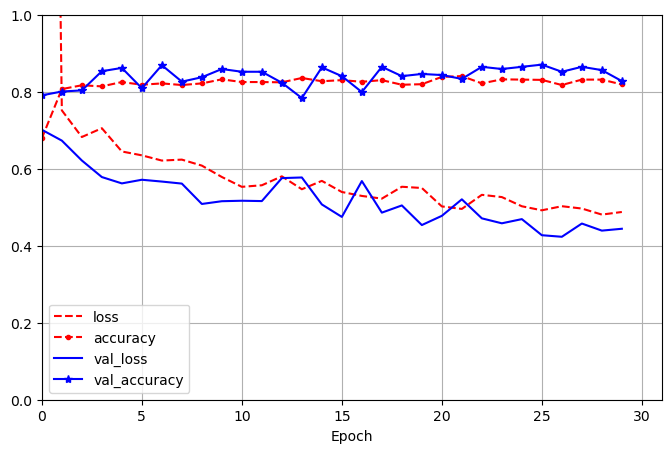

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 100)               2400      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 100)               10100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 100)               10100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_12 (Dense)            (None, 4)                

In [59]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 31], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.show()

model_5.summary()

# Neural Network - After resample

In [61]:
history=model_1.fit(x=resample_data_train, y=resample_labels_train, validation_data=(data_test, labels_test), epochs=30)

Epoch 1/30
104/104 [==============================] - 0s 2ms/step - loss: 0.8083 - accuracy: 0.7487 - val_loss: 1.1179 - val_accuracy: 0.6610
Epoch 2/30
104/104 [==============================] - 0s 2ms/step - loss: 0.6690 - accuracy: 0.7726 - val_loss: 0.8303 - val_accuracy: 0.7293
Epoch 3/30
104/104 [==============================] - 0s 2ms/step - loss: 0.6048 - accuracy: 0.7832 - val_loss: 0.7868 - val_accuracy: 0.7422
Epoch 4/30
104/104 [==============================] - 0s 2ms/step - loss: 0.5834 - accuracy: 0.7956 - val_loss: 0.7057 - val_accuracy: 0.7550
Epoch 5/30
104/104 [==============================] - 0s 2ms/step - loss: 0.5642 - accuracy: 0.7996 - val_loss: 0.6025 - val_accuracy: 0.7749
Epoch 6/30
104/104 [==============================] - 0s 2ms/step - loss: 0.5282 - accuracy: 0.8081 - val_loss: 0.6202 - val_accuracy: 0.7707
Epoch 7/30
104/104 [==============================] - 0s 2ms/step - loss: 0.5333 - accuracy: 0.8038 - val_loss: 0.7165 - val_accuracy: 0.7464
Epoch 

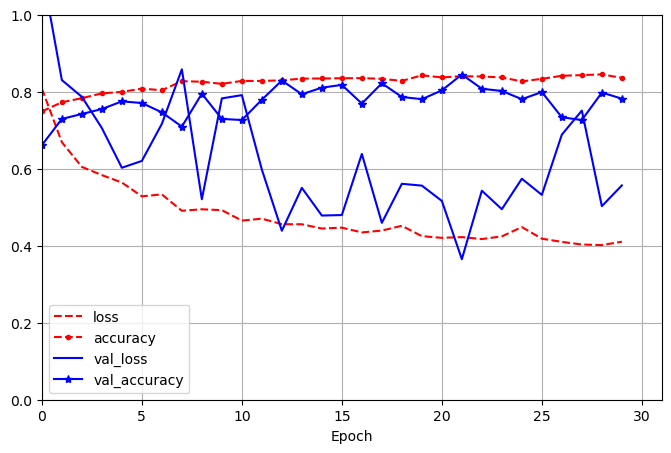

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 96        
                                                                 
Total params: 96
Trainable params: 96
Non-trainable params: 0
_________________________________________________________________


In [62]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 31], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.show()

model_1.summary()

In [63]:
history=model_2.fit(x=resample_data_train, y=resample_labels_train, validation_data=(data_test, labels_test), epochs=30)

Epoch 1/30
104/104 [==============================] - 0s 2ms/step - loss: 0.5808 - accuracy: 0.8005 - val_loss: 0.8444 - val_accuracy: 0.7536
Epoch 2/30
104/104 [==============================] - 0s 2ms/step - loss: 0.4568 - accuracy: 0.8347 - val_loss: 0.2746 - val_accuracy: 0.8818
Epoch 3/30
104/104 [==============================] - 0s 2ms/step - loss: 0.3896 - accuracy: 0.8420 - val_loss: 0.2683 - val_accuracy: 0.8860
Epoch 4/30
104/104 [==============================] - 0s 2ms/step - loss: 0.3948 - accuracy: 0.8550 - val_loss: 0.3437 - val_accuracy: 0.8618
Epoch 5/30
104/104 [==============================] - 0s 2ms/step - loss: 0.4728 - accuracy: 0.8344 - val_loss: 0.3470 - val_accuracy: 0.8490
Epoch 6/30
104/104 [==============================] - 0s 2ms/step - loss: 0.3914 - accuracy: 0.8483 - val_loss: 0.8442 - val_accuracy: 0.7550
Epoch 7/30
104/104 [==============================] - 0s 2ms/step - loss: 0.3652 - accuracy: 0.8565 - val_loss: 1.0620 - val_accuracy: 0.6795
Epoch 

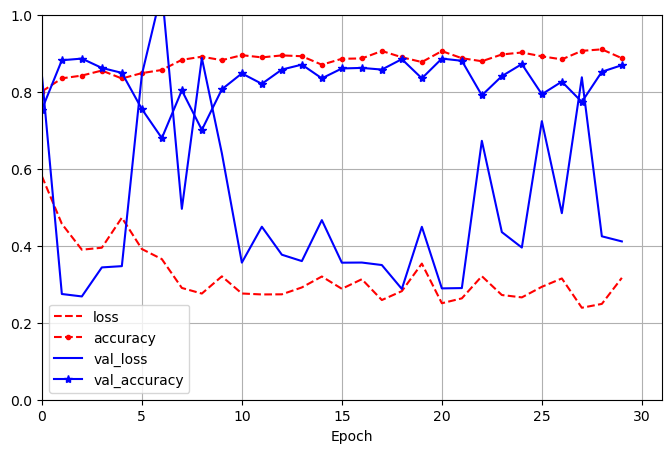

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 100)               2400      
                                                                 
 dense_2 (Dense)             (None, 5)                 505       
                                                                 
Total params: 2,905
Trainable params: 2,905
Non-trainable params: 0
_________________________________________________________________


In [64]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 31], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.show()

model_2.summary()

In [65]:
history=model_3.fit(x=resample_data_train, y=resample_labels_train, validation_data=(data_test, labels_test), epochs=30)

Epoch 1/30
104/104 [==============================] - 0s 2ms/step - loss: 0.4107 - accuracy: 0.8302 - val_loss: 0.5631 - val_accuracy: 0.7635
Epoch 2/30
104/104 [==============================] - 0s 2ms/step - loss: 0.4100 - accuracy: 0.8305 - val_loss: 0.3699 - val_accuracy: 0.8348
Epoch 3/30
104/104 [==============================] - 0s 2ms/step - loss: 0.4037 - accuracy: 0.8289 - val_loss: 0.4490 - val_accuracy: 0.7949
Epoch 4/30
104/104 [==============================] - 0s 2ms/step - loss: 0.4222 - accuracy: 0.8193 - val_loss: 0.4086 - val_accuracy: 0.8276
Epoch 5/30
104/104 [==============================] - 0s 2ms/step - loss: 0.3414 - accuracy: 0.8559 - val_loss: 0.4300 - val_accuracy: 0.8120
Epoch 6/30
104/104 [==============================] - 0s 2ms/step - loss: 0.3564 - accuracy: 0.8565 - val_loss: 0.4021 - val_accuracy: 0.8291
Epoch 7/30
104/104 [==============================] - 0s 2ms/step - loss: 0.3500 - accuracy: 0.8538 - val_loss: 0.9976 - val_accuracy: 0.6353
Epoch 

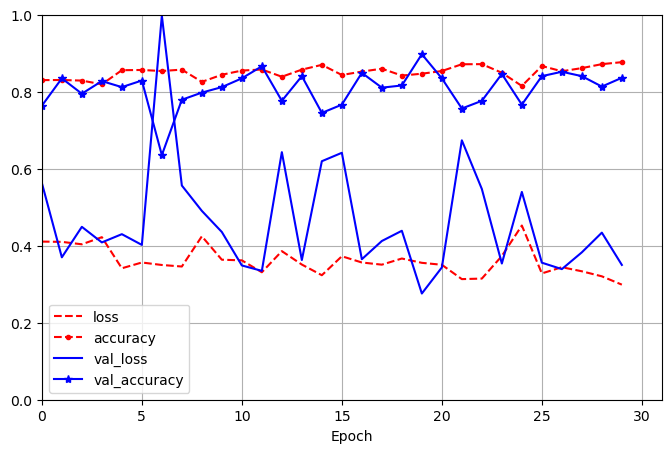

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               2400      
                                                                 
 dense_4 (Dense)             (None, 5)                 505       
                                                                 
Total params: 2,905
Trainable params: 2,905
Non-trainable params: 0
_________________________________________________________________


In [66]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 31], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.show()

model_3.summary()

In [67]:
history=model_4.fit(x=resample_data_train, y=resample_labels_train, validation_data=(data_test, labels_test), epochs=30)

Epoch 1/30
104/104 [==============================] - 0s 2ms/step - loss: 0.4380 - accuracy: 0.8162 - val_loss: 0.5372 - val_accuracy: 0.7194
Epoch 2/30
104/104 [==============================] - 0s 2ms/step - loss: 0.4670 - accuracy: 0.7917 - val_loss: 0.3231 - val_accuracy: 0.8575
Epoch 3/30
104/104 [==============================] - 0s 2ms/step - loss: 0.4162 - accuracy: 0.8165 - val_loss: 0.4325 - val_accuracy: 0.7877
Epoch 4/30
104/104 [==============================] - 0s 2ms/step - loss: 0.4142 - accuracy: 0.8196 - val_loss: 0.4365 - val_accuracy: 0.8077
Epoch 5/30
104/104 [==============================] - 0s 2ms/step - loss: 0.3821 - accuracy: 0.8283 - val_loss: 0.5141 - val_accuracy: 0.7550
Epoch 6/30
104/104 [==============================] - 0s 2ms/step - loss: 0.4142 - accuracy: 0.8283 - val_loss: 0.3285 - val_accuracy: 0.8647
Epoch 7/30
104/104 [==============================] - 0s 2ms/step - loss: 0.3591 - accuracy: 0.8474 - val_loss: 0.3670 - val_accuracy: 0.8376
Epoch 

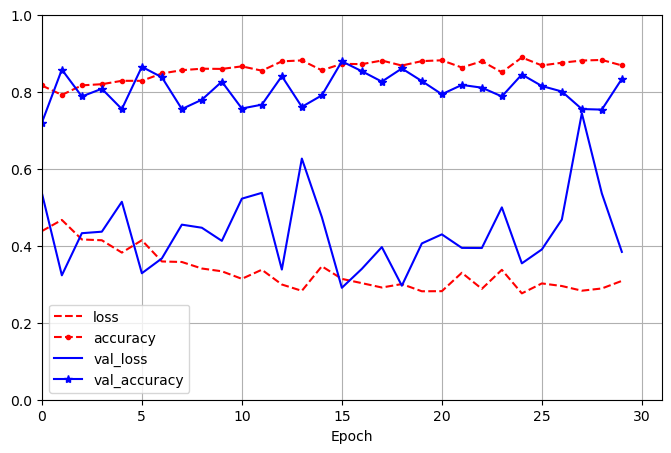

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 100)               2400      
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 100)               10100     
                                                                 
 dense_8 (Dense)             (None, 5)                 505       
                                                                 
Total params: 23,105
Trainable params: 23,105
Non-trainable params: 0
_________________________________________________________________


In [68]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 31], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.show()

model_4.summary()

In [69]:
now=time.time()
history=model_5.fit(x=resample_data_train, y=resample_labels_train, validation_data=(data_test, labels_test), epochs=30)
end=time.time()
duration=end-now
print("Duration: {}".format(duration))

Epoch 1/30
104/104 [==============================] - 0s 3ms/step - loss: 0.7472 - accuracy: 0.6960 - val_loss: 0.7899 - val_accuracy: 0.6595
Epoch 2/30
104/104 [==============================] - 0s 2ms/step - loss: 0.7496 - accuracy: 0.7081 - val_loss: 0.4880 - val_accuracy: 0.8362
Epoch 3/30
104/104 [==============================] - 0s 3ms/step - loss: 0.7137 - accuracy: 0.7187 - val_loss: 0.6049 - val_accuracy: 0.8191
Epoch 4/30
104/104 [==============================] - 0s 3ms/step - loss: 0.6837 - accuracy: 0.7257 - val_loss: 0.4709 - val_accuracy: 0.8390
Epoch 5/30
104/104 [==============================] - 0s 3ms/step - loss: 0.6903 - accuracy: 0.7284 - val_loss: 0.5711 - val_accuracy: 0.7821
Epoch 6/30
104/104 [==============================] - 0s 2ms/step - loss: 0.6852 - accuracy: 0.7345 - val_loss: 0.6536 - val_accuracy: 0.7450
Epoch 7/30
104/104 [==============================] - 0s 2ms/step - loss: 0.6593 - accuracy: 0.7484 - val_loss: 0.7860 - val_accuracy: 0.6667
Epoch 

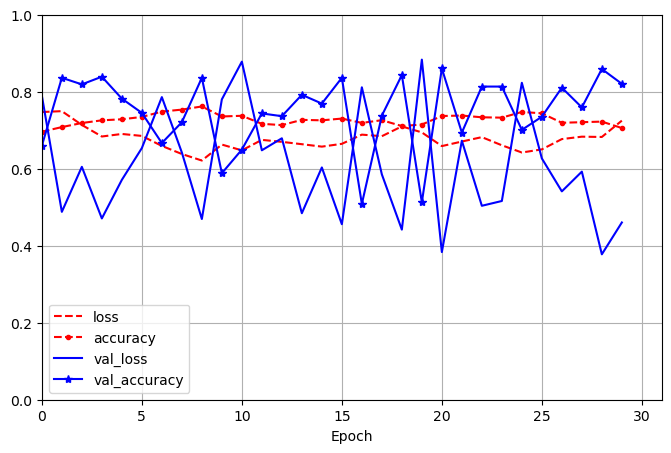

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 100)               2400      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 100)               10100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 100)               10100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_12 (Dense)            (None, 4)                

In [70]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 31], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.show()

model_5.summary()

In [114]:
#Model 5 show sign of overfitting so decreasing in learning rate and number of hidden layer might help overfitting 
opt_6 = Adam(learning_rate=0.001)

model_6 = Sequential([layers.Input(23),
                     layers.Dense(100, activation='relu', kernel_regularizer=L2(0.001)),
                     layers.Dropout(0.2),
                     layers.Dense(100, activation='relu', kernel_regularizer=L2(0.001)),
                     layers.Dropout(0.2),
                     layers.Dense(4, activation='softmax')
                     ])
model_6.compile(optimizer=opt_6, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [115]:
now=time.time()
history=model_6.fit(x=resample_data_train, y=resample_labels_train, validation_data=(data_test, labels_test), epochs=50)
end=time.time()
duration=end-now
print("Duration: {}".format(duration))

Epoch 1/50
104/104 [==============================] - 1s 3ms/step - loss: 8.0810 - accuracy: 0.4862 - val_loss: 1.1364 - val_accuracy: 0.6909
Epoch 2/50
104/104 [==============================] - 0s 2ms/step - loss: 1.9817 - accuracy: 0.5937 - val_loss: 0.9322 - val_accuracy: 0.5627
Epoch 3/50
104/104 [==============================] - 0s 2ms/step - loss: 1.2109 - accuracy: 0.5937 - val_loss: 0.8553 - val_accuracy: 0.7137
Epoch 4/50
104/104 [==============================] - 0s 2ms/step - loss: 0.9524 - accuracy: 0.6555 - val_loss: 0.7476 - val_accuracy: 0.7308
Epoch 5/50
104/104 [==============================] - 0s 2ms/step - loss: 0.8395 - accuracy: 0.6903 - val_loss: 0.7056 - val_accuracy: 0.7664
Epoch 6/50
104/104 [==============================] - 0s 2ms/step - loss: 0.7808 - accuracy: 0.7094 - val_loss: 0.6578 - val_accuracy: 0.7949
Epoch 7/50
104/104 [==============================] - 0s 2ms/step - loss: 0.7431 - accuracy: 0.7239 - val_loss: 0.5729 - val_accuracy: 0.8219
Epoch 

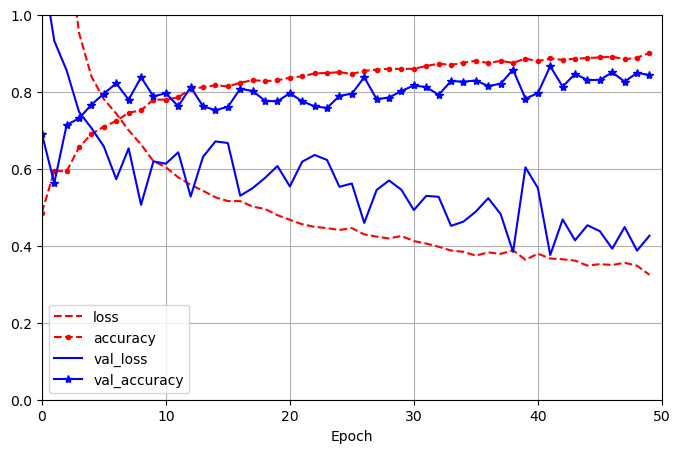

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_59 (Dense)            (None, 100)               2400      
                                                                 
 dropout_34 (Dropout)        (None, 100)               0         
                                                                 
 dense_60 (Dense)            (None, 100)               10100     
                                                                 
 dropout_35 (Dropout)        (None, 100)               0         
                                                                 
 dense_61 (Dense)            (None, 4)                 404       
                                                                 
Total params: 12,904
Trainable params: 12,904
Non-trainable params: 0
_________________________________________________________________


In [116]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 50], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.show()

model_6.summary()